# Deep Learning Projekt

## Data mining

In [3]:
#!pip install torch
#!pip install torch-geometric
#!pip install iso3166
import pandas as pd
import torch
from torch_geometric.data import Data
from iso3166 import countries
import numpy as np



# Trade Flow + Graph building

In [4]:
import os
import pandas as pd
import torch
from torch_geometric.data import Data
from iso3166 import countries

# Config
FOLDER = "TradeData"
YEARS = range(2000, 2023)


# Load CEPII country → ISO3 map
country_path = os.path.join(FOLDER, "country_codes_V202501.csv")
df_country = pd.read_csv(country_path, sep=None, engine='python')
df_country.columns = df_country.columns.str.strip()

rename_map = {
    'country_code': 'code',
    'country_iso3': 'iso3',
    'country_iso2': 'iso2',
    'country_name': 'name'
}
df_country = df_country.rename(columns={k: v for k, v in rename_map.items() if k in df_country.columns})
df_country['code'] = df_country['code'].astype(int)
df_country['iso3'] = df_country['iso3'].str.strip()
code_to_iso = dict(zip(df_country['code'], df_country['iso3']))

valid_iso3 = {c.alpha3 for c in countries}


# Load ALL BACI years into one dataframe (keep the 'year' column)
dfs = []
for y in YEARS:
    fn = f"BACI_HS92_Y{y}_v202501.csv"
    path = os.path.join(FOLDER, fn)
    if not os.path.exists(path):
        print(f" missing: {fn}")
        continue

    df = pd.read_csv(path, sep=',', low_memory=False)

    required = {'i', 'j', 'v'}
    if not required.issubset(df.columns):
        print(f"{fn} does not contain columns {required}. Found: {df.columns.tolist()}")
        continue

    df = df[['i', 'j', 'v']].copy()
    df['year'] = y
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

# Map CEPII integer codes to ISO3 and filter valid ISO3
df_all['i'] = df_all['i'].astype(int)
df_all['j'] = df_all['j'].astype(int)
df_all['source'] = df_all['i'].map(code_to_iso)
df_all['target'] = df_all['j'].map(code_to_iso)
df_all = df_all.dropna(subset=['source', 'target'])
df_all = df_all[df_all['source'].isin(valid_iso3) & df_all['target'].isin(valid_iso3)]

# Create a GLOBAL country_to_id so that every yearly graph uses the same node indices
all_countries = pd.unique(df_all[['source', 'target']].values.ravel())
country_to_id = {iso: i for i, iso in enumerate(sorted(all_countries))}
num_nodes = len(country_to_id)

print(f"Total countries across all years: {num_nodes}")

# Build one PyG Data() object PER YEAR
graphs = {}

for y in YEARS:
    df_y = df_all[df_all['year'] == y]
    if df_y.empty:
        print(f" no data for year {y}, skipping")
        continue

    # Aggregate within the year (sum over products HS6)
    df_y = (df_y.groupby(['source', 'target'])['v']
                 .sum()
                 .reset_index()
                 .rename(columns={'v': 'trade_value_usd'}))

    # Log-normalize the trade value
    df_y['export_score'] = df_y['trade_value_usd'].apply(lambda x: np.log1p(x))

    # Map to node ids
    df_y['source_id'] = df_y['source'].map(country_to_id)
    df_y['target_id'] = df_y['target'].map(country_to_id)

    # Build tensors
    edge_index = torch.tensor(df_y[['source_id', 'target_id']].values.T, dtype=torch.long)
    edge_weight = torch.tensor(df_y['export_score'].values, dtype=torch.float)

    # Dummy node features for now (replace later with GDP/HDI/etc. per year)
    x = torch.ones((num_nodes, 1))

    data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)
    data.year = y  # store year inside the Data object
    graphs[y] = data

print(f"Built {len(graphs)} yearly graphs.")
print(graphs[2022])  # example


Total countries across all years: 226
Built 23 yearly graphs.
Data(x=[226, 1], edge_index=[2, 31585], edge_weight=[31585], year=2022)


In [5]:
print(graphs[2001])  


Data(x=[226, 1], edge_index=[2, 25838], edge_weight=[25838], year=2001)


# GDP

In [6]:
# Load World Bank GDP data 
gdp_path = os.path.join("worldbank_gdp_data", "API_NY.GDP.MKTP.CD_DS2_en_csv_v2_38344.csv")
df_gdp = pd.read_csv(gdp_path, skiprows=4)

exclude_keywords = [
    'Africa', 'World', 'OECD', 'Europe', 'Arab', 'income', 'IDA', 'IBRD',
    'Latin America', 'Middle East', 'Sub-Saharan', 'East Asia', 'Euro area'
]
df_gdp = df_gdp[~df_gdp['Country Name'].str.contains('|'.join(exclude_keywords), case=False, na=False)]
df_gdp = df_gdp.rename(columns={'Country Code': 'ISO3'})
df_gdp = df_gdp[['ISO3'] + [str(y) for y in range(2000, 2023)]]

# safe befor Interpolation
df_gdp_before_interp = df_gdp.copy()

# linear Interpolation
df_gdp.iloc[:, 1:] = (
    df_gdp.iloc[:, 1:]
    .transpose()
    .interpolate(method='linear', limit_direction='both')
    .transpose()
)

# Safe after Interpolation
df_gdp_after_interp = df_gdp.copy()

# normalization
df_gdp.iloc[:, 1:] = df_gdp.iloc[:, 1:].apply(
    lambda col: (col - col.mean()) / (col.std() + 1e-8),
    axis=0
)

gdp_lookup = {
    y: df_gdp.set_index('ISO3')[str(y)].to_dict()
    for y in range(2000, 2023)
}

# nodes into graph
for year, data in graphs.items():
    x = torch.full((num_nodes, 1), float('nan'))  

    for iso3, idx in country_to_id.items():
        val = gdp_lookup.get(year, {}).get(iso3, float('nan'))
        x[idx] = float(val)

    
    x[torch.isnan(x)] = 0.0

    data.x = x

# remove nans
df_gdp = df_gdp.dropna()



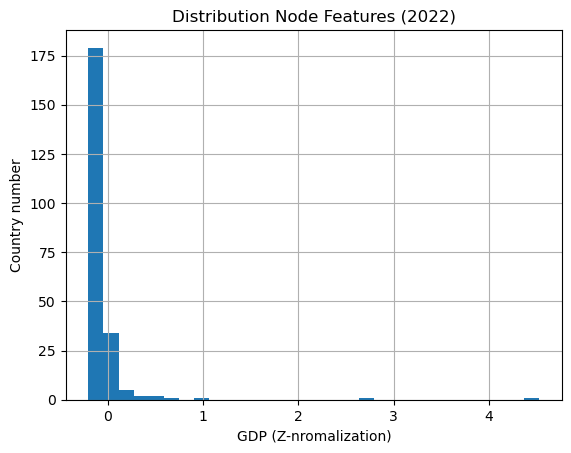

In [7]:
import matplotlib.pyplot as plt

values = graphs[2015].x.squeeze().numpy()
plt.hist(values, bins=30)
plt.title("Distribution Node Features (2022)")
plt.xlabel("GDP (Z-nromalization)")
plt.ylabel("Country number")
plt.grid(True)
plt.show()


In [8]:
iso = "DEU"  
year = 2022
node_id = country_to_id[iso]
gdp_value = graphs[year].x[node_id].item()

print(f"GDP-Feature for {iso} in the year {year}: {gdp_value}")

GDP-Feature for DEU in the year 2022: 0.5909050107002258


In [9]:
print("still nans??", df_gdp.isna().values.any())

print("\nnumber of missings per year")
print(df_gdp.isna().sum())

if df_gdp.isna().values.any():
    print("\nCountry with missings")
    print(df_gdp[df_gdp.isna().any(axis=1)]['ISO3'].tolist())


still nans?? False

number of missings per year
ISO3    0
2000    0
2001    0
2002    0
2003    0
2004    0
2005    0
2006    0
2007    0
2008    0
2009    0
2010    0
2011    0
2012    0
2013    0
2014    0
2015    0
2016    0
2017    0
2018    0
2019    0
2020    0
2021    0
2022    0
dtype: int64


# GDP per capita

In [10]:
import os
import io
import zipfile
import requests
import pandas as pd
import torch

YEARS = range(2000, 2023)
INDICATOR = "NY.GDP.PCAP.CD"   
WB_OUTDIR = "worldbank_gdp_pcap"

os.makedirs(WB_OUTDIR, exist_ok=True)


# Download and extract
url = f"http://api.worldbank.org/v2/en/indicator/{INDICATOR}?downloadformat=csv"
resp = requests.get(url)
with zipfile.ZipFile(io.BytesIO(resp.content)) as z:
    z.extractall(WB_OUTDIR)

pcap_csv = [f for f in os.listdir(WB_OUTDIR)
            if f.startswith(f"API_{INDICATOR}") and f.endswith(".csv")][0]


# Load & clean
df_pcap = pd.read_csv(os.path.join(WB_OUTDIR, pcap_csv), skiprows=4)

# Drop aggregates (regions, groups, etc.)
exclude_keywords = [
    'Africa', 'World', 'OECD', 'Europe', 'Arab', 'income', 'IDA', 'IBRD',
    'Latin America', 'Middle East', 'Sub-Saharan', 'East Asia', 'Euro area'
]
df_pcap = df_pcap[~df_pcap['Country Name'].str.contains('|'.join(exclude_keywords), case=False, na=False)]

# Keep ISO3 + years
year_cols = [str(y) for y in YEARS]
df_pcap = df_pcap.rename(columns={'Country Code': 'ISO3'})
df_pcap = df_pcap[['ISO3'] + year_cols].copy()

# Convert columns to numeric
df_pcap[year_cols] = df_pcap[year_cols].apply(pd.to_numeric, errors='coerce')

# Save  befor interpolation
df_pcap_before_interp = df_pcap.copy()

# linear Interpolation
df_pcap[year_cols] = (
    df_pcap[year_cols]
    .transpose()
    .interpolate(method='linear', limit_direction='both')
    .transpose()
)

#  Save after interpolation
df_pcap_after_interp = df_pcap.copy()

# remove nans
df_pcap = df_pcap.dropna()

# Standardize per year (Z-score)
df_pcap[year_cols] = df_pcap[year_cols].apply(
    lambda col: (col - col.mean()) / (col.std() + 1e-8),
    axis=0
)

pcap_lookup = {
    y: df_pcap.set_index('ISO3')[str(y)].to_dict()
    for y in YEARS
}


# Push GDP per capita into graphs[year].x as a second column
for year, data in graphs.items():
    if data.x.dim() == 1:
        data.x = data.x.unsqueeze(1)

    pcap_feat = torch.zeros((num_nodes, 1), dtype=torch.float32)

    for iso3, idx in country_to_id.items():
        val = pcap_lookup.get(year, {}).get(iso3, 0.0) 
        pcap_feat[idx, 0] = float(val)

    data.x = torch.cat([data.x, pcap_feat], dim=1)

print("Example shape after adding GDP per capita:", graphs[2022].x.shape)
print("First 5 rows of node features for 2022:\n", graphs[2022].x[:5])


Example shape after adding GDP per capita: torch.Size([226, 2])
First 5 rows of node features for 2022:
 tensor([[-0.2065,  0.3255],
        [-0.2044, -0.6621],
        [-0.1871, -0.5780],
        [ 0.0000,  0.0000],
        [-0.2035, -0.4499]])


In [11]:
print(graphs[2022].x.shape)   
print(graphs[2022].x[:10])    

torch.Size([226, 2])
tensor([[-0.2065,  0.3255],
        [-0.2044, -0.6621],
        [-0.1871, -0.5780],
        [ 0.0000,  0.0000],
        [-0.2035, -0.4499],
        [-0.2065,  0.7132],
        [ 0.0000,  0.0000],
        [-0.0859, -0.2181],
        [-0.2034, -0.4589],
        [-0.2070, -0.0846]])


In [12]:
import torch

x_2022 = graphs[2022].x
print("NaNs in data.x (2022)?", torch.isnan(x_2022).any().item())


print("\nNaNs per Feature-column (2022):")
print(torch.isnan(x_2022).sum(dim=0))

for year, data in graphs.items():
    if torch.isnan(data.x).any():
        print(f"NaNs in data.x for year: {year}")


NaNs in data.x (2022)? False

NaNs per Feature-column (2022):
tensor([0, 0])


# Expense (Goverment Spending)

In [13]:
import os
import io
import zipfile
import requests
import pandas as pd
import torch

YEARS = range(2000, 2023)
INDICATOR = "GC.XPN.TOTL.GD.ZS"  # Government spending (% of GDP)
OUTDIR = "worldbank_gov_spending"

os.makedirs(OUTDIR, exist_ok=True)

# Download
url = f"http://api.worldbank.org/v2/en/indicator/{INDICATOR}?downloadformat=csv"
resp = requests.get(url)
with zipfile.ZipFile(io.BytesIO(resp.content)) as z:
    z.extractall(OUTDIR)

csv_file = [f for f in os.listdir(OUTDIR) if f.startswith(f"API_{INDICATOR}") and f.endswith(".csv")][0]


# clear data
df_gov = pd.read_csv(os.path.join(OUTDIR, csv_file), skiprows=4)
exclude = ['Africa', 'World', 'OECD', 'Europe', 'Arab', 'income', 'IDA', 'IBRD',
           'Latin America', 'Middle East', 'Sub-Saharan', 'East Asia', 'Euro area']
df_gov = df_gov[~df_gov['Country Name'].str.contains('|'.join(exclude), case=False, na=False)]
df_gov = df_gov.rename(columns={'Country Code': 'ISO3'})
year_cols = [str(y) for y in YEARS]
df_gov = df_gov[['ISO3'] + year_cols].copy()

df_gov[year_cols] = df_gov[year_cols].apply(pd.to_numeric, errors='coerce')

# safe befor interpolation
df_gov_before_interp = df_gov.copy()

# Interpolation 
df_gov[year_cols] = (
    df_gov[year_cols]
    .transpose()
    .interpolate(method='linear', limit_direction='both')
    .transpose()
)

# safe after interpolation
df_gov_after_interp = df_gov.copy()
df_gov = df_gov.dropna(subset=year_cols, how='any')

# normalization
df_gov[year_cols] = df_gov[year_cols].apply(
    lambda col: (col - col.mean()) / (col.std() + 1e-8),
    axis=0
)

gov_lookup = {y: df_gov.set_index('ISO3')[str(y)].to_dict() for y in YEARS}

# set feature for graphs
for year, data in graphs.items():
    if data.x.dim() == 1:
        data.x = data.x.unsqueeze(1)

    gov_feat = torch.zeros((num_nodes, 1), dtype=torch.float32)
    for iso3, idx in country_to_id.items():
        val = gov_lookup.get(year, {}).get(iso3, 0.0) 
        gov_feat[idx, 0] = float(val)

    data.x = torch.cat([data.x, gov_feat], dim=1)

print("Feature-Matrix for 2022:", graphs[2022].x.shape)
print("First 5 Nodes:\n", graphs[2022].x[:5])


Feature-Matrix for 2022: torch.Size([226, 3])
First 5 Nodes:
 tensor([[-0.2065,  0.3255,  0.0000],
        [-0.2044, -0.6621,  0.8660],
        [-0.1871, -0.5780, -0.8276],
        [ 0.0000,  0.0000,  0.0000],
        [-0.2035, -0.4499, -0.0521]])


In [14]:
import torch

print("NaNs in Graph-Features?", any(torch.isnan(data.x).any().item() for data in graphs.values()))

for year, data in graphs.items():
    if torch.isnan(data.x).any():
        print(f"NaNs in year {year}: {torch.isnan(data.x).sum(dim=0).tolist()}")


NaNs in Graph-Features? False


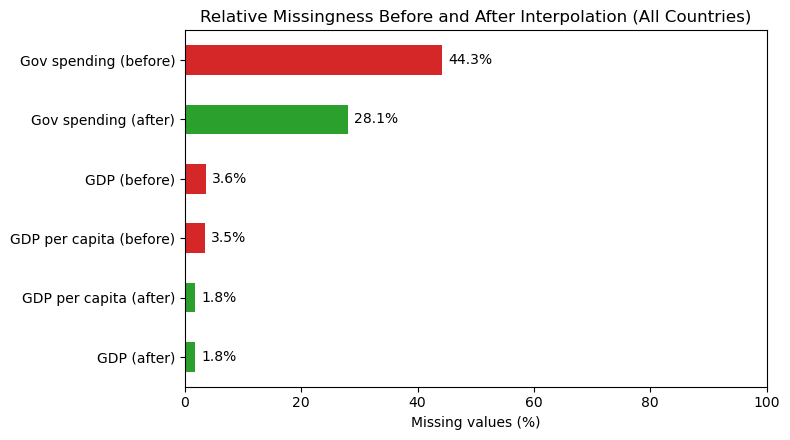

In [15]:
# visualization Naans
import matplotlib.pyplot as plt
import pandas as pd

year_cols = [str(y) for y in range(2000, 2023)]

def get_missing_pct(df):
    total = df[year_cols].size
    missing = df[year_cols].isna().sum().sum()
    return 100 * missing / total

missing_pct = {
    "GDP (before)": get_missing_pct(df_gdp_before_interp),
    "GDP (after)":  get_missing_pct(df_gdp_after_interp),
    "GDP per capita (before)": get_missing_pct(df_pcap_before_interp),
    "GDP per capita (after)":  get_missing_pct(df_pcap_after_interp),
    "Gov spending (before)": get_missing_pct(df_gov_before_interp),
    "Gov spending (after)":  get_missing_pct(df_gov_after_interp),
}


missing_series = pd.Series(missing_pct).sort_values()


plt.figure(figsize=(8, 4.5))
ax = missing_series.plot.barh(color=["#d62728" if "before" in k else "#2ca02c" for k in missing_series.index])
ax.set_xlabel("Missing values (%)")
ax.set_title("Relative Missingness Before and After Interpolation (All Countries)")
ax.set_xlim(0, 100)

for i, v in enumerate(missing_series.values):
    ax.text(v + 1, i, f"{v:.1f}%", va="center")

plt.tight_layout()
plt.show()


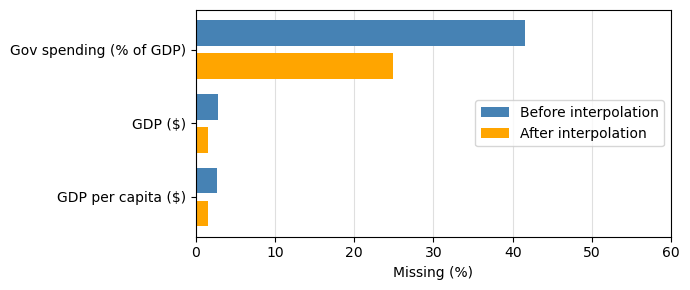

In [16]:
# relative missingness on UN countries
def get_missing_pct_un(df_before, df_after, name):
    un_iso3 = set(df_country['iso3'])
    df_b = df_before[df_before['ISO3'].isin(un_iso3)]
    df_a = df_after[df_after['ISO3'].isin(un_iso3)]
    year_cols = [str(y) for y in range(2000, 2023)]

    total_b = df_b[year_cols].size
    total_a = df_a[year_cols].size
    miss_b = df_b[year_cols].isna().sum().sum()
    miss_a = df_a[year_cols].isna().sum().sum()

    pct_b = round(100 * miss_b / total_b, 1)
    pct_a = round(100 * miss_a / total_a, 1)

    return (name, pct_b, pct_a)

entries = [
    get_missing_pct_un(df_gdp_before_interp, df_gdp_after_interp, "GDP ($)"),
    get_missing_pct_un(df_pcap_before_interp, df_pcap_after_interp, "GDP per capita ($)"),
    get_missing_pct_un(df_gov_before_interp, df_gov_after_interp, "Gov spending (% of GDP)"),
]


names = [e[0] for e in entries]
pct_before = pd.Series([e[1] for e in entries], index=names)
pct_after  = pd.Series([e[2] for e in entries], index=names)

pct_after = pct_after.reindex(pct_before.index)
order = pct_before.sort_values(ascending=True).index
pct_before = pct_before.loc[order]
pct_after = pct_after.loc[order]


y = np.arange(len(pct_before))
h = 0.35
gap = 0.10

plt.figure(figsize=(7, 3))
ax = plt.gca()

# bars
ax.barh(y + h/2 + gap/2, pct_before.values, height=h, label="Before interpolation", color="steelblue", alpha=1)
ax.barh(y - h/2 - gap/2, pct_after.values,  height=h, label="After interpolation", color="orange", alpha=1)

# axis config
ax.set_xlabel("Missing (%)")
ax.set_yticks(y)
ax.set_yticklabels(pct_before.index)
ax.set_xlim(0, 60)
ax.set_axisbelow(True)
ax.grid(axis="x", linestyle="-", alpha=0.4)
ax.legend(loc="center right", frameon=True)

plt.tight_layout()
plt.show()



In [17]:
un_iso3 = set(df_country['iso3'])
years = [str(y) for y in range(2000, 2023)]

def missing_pct(df, name):
    df_un = df[df['ISO3'].isin(un_iso3)].copy()
    total = df_un[years].size
    missing = df_un[years].isna().sum().sum()
    percent = round(100 * missing / total, 2)
    print(f"{name}: {percent}% missing values")

# GDP
missing_pct(df_gdp_before_interp, "GDP before interp")
missing_pct(df_gdp_after_interp,  "GDP after interp")

# GDP per capita
missing_pct(df_pcap_before_interp, "GDP per capita before interp")
missing_pct(df_pcap_after_interp,  "GDP per capita after interp")

# Government spending
missing_pct(df_gov_before_interp, "Gov spending before interp")
missing_pct(df_gov_after_interp,  "Gov spending after interp")


GDP before interp: 2.83% missing values
GDP after interp: 1.49% missing values
GDP per capita before interp: 2.75% missing values
GDP per capita after interp: 1.49% missing values
Gov spending before interp: 41.51% missing values
Gov spending after interp: 24.88% missing values


# GINI

In [18]:
import pandas as pd
import torch

# Load GINI CSV 
df_gini = pd.read_csv("gini_data.csv", skiprows=4)

# Clean and reshape
df_gini = df_gini.rename(columns={'Country Code': 'ISO3'})
year_cols = [col for col in df_gini.columns if col.isdigit()]
df_gini = df_gini[['ISO3'] + year_cols]

gini_lookup = {
    int(year): df_gini.set_index('ISO3')[year].to_dict()
    for year in year_cols
}

# Assign per-year GINI with masking
for year, data in graphs.items():
    y = torch.full((data.num_nodes,), float('nan'))  
    mask = torch.zeros((data.num_nodes,), dtype=torch.bool)  

    for iso3, idx in country_to_id.items():
        val = gini_lookup.get(year, {}).get(iso3, None)
        if val is not None and not pd.isna(val):
            y[idx] = val
            mask[idx] = True

    data.y = y
    data.train_mask = mask

print("Gini and train mask set")
print("Example (2022):", graphs[2020].y.shape, "→", graphs[2020].train_mask.sum().item(), "true values")




Gini and train mask set
Example (2022): torch.Size([226]) → 67 true values


## Removing Aggregates

In [19]:
from torch_geometric.data import Data

meta_path = os.path.join("worldbank_gdp_data", "Metadata_Country_API_NY.GDP.MKTP.CD_DS2_en_csv_v2_38344.csv")


meta = pd.read_csv(meta_path)
meta.columns = [c.strip() for c in meta.columns]


valid_iso3_wb = set(meta.loc[meta['Region'] != 'Aggregates', 'Country Code'].dropna().unique())

print(f"Valid WB country ISO3 codes (no aggregates): {len(valid_iso3_wb)}")

id_to_iso = {v: k for k, v in country_to_id.items()}
num_nodes = len(id_to_iso)

keep_nodes = [nid for nid, iso in id_to_iso.items() if iso in valid_iso3_wb]
keep_mask = torch.zeros(num_nodes, dtype=torch.bool)
keep_mask[keep_nodes] = True

print(f"Keeping {keep_mask.sum().item()} / {num_nodes} nodes")

# map nod ids
old_to_new = -torch.ones(num_nodes, dtype=torch.long)
old_to_new[keep_mask] = torch.arange(keep_mask.sum().item())

# filter graph


def filter_graph(data: Data, keep_mask: torch.Tensor, old_to_new: torch.Tensor) -> Data:
    x = data.x[keep_mask]

    y = data.y[keep_mask] if hasattr(data, 'y') else None
    train_mask = data.train_mask[keep_mask] if hasattr(data, 'train_mask') else None
    val_mask   = data.val_mask[keep_mask]   if hasattr(data, 'val_mask') else None
    test_mask  = data.test_mask[keep_mask]  if hasattr(data, 'test_mask') else None

    ei = data.edge_index
    src, dst = ei[0], ei[1]
    edge_keep = keep_mask[src] & keep_mask[dst]
    ei = ei[:, edge_keep]

    ei = old_to_new[ei]

    edge_weight = data.edge_weight[edge_keep] if hasattr(data, 'edge_weight') else None

    new_data = Data(x=x, edge_index=ei)
    if edge_weight is not None:
        new_data.edge_weight = edge_weight
    if y is not None:
        new_data.y = y
    if train_mask is not None:
        new_data.train_mask = train_mask
    if val_mask is not None:
        new_data.val_mask   = val_mask
    if test_mask is not None:
        new_data.test_mask  = test_mask

    
    if hasattr(data, 'year'):
        new_data.year = data.year
    if hasattr(data, 'iso3'):
        
        iso3_list = [iso for nid, iso in id_to_iso.items() if keep_mask[nid].item()]
        new_data.iso3 = iso3_list

    return new_data

# use function on all graphs
filtered_graphs = {}
for y, g in graphs.items():
    filtered_graphs[y] = filter_graph(g, keep_mask, old_to_new)

graphs = filtered_graphs 

new_id_to_iso = [id_to_iso[old] for old in range(num_nodes) if keep_mask[old].item()]
new_country_to_id = {iso: i for i, iso in enumerate(new_id_to_iso)}

print(f"Done. Example (2022): {graphs[2022]}")
print(f"Nodes kept: {graphs[2022].num_nodes}")

Valid WB country ISO3 codes (no aggregates): 265
Keeping 208 / 226 nodes
Done. Example (2022): Data(x=[208, 3], edge_index=[2, 30066], edge_weight=[30066], y=[208], train_mask=[208], year=2022)
Nodes kept: 208


In [20]:
# set ISO3-Labels
new_iso3_list = [id_to_iso[old] for old in range(len(keep_mask)) if keep_mask[old].item()]
for year in graphs:
    graphs[year].iso3 = new_iso3_list


# Merging

In [21]:
import torch
from torch_geometric.data import Data

def merge_yearly_graphs(
    graphs: dict,
    years: list = None,
    add_temporal_self_edges: bool = False,
    keep_masks: bool = True
):
    """
    Merge a dict[int -> Data] of same-sized yearly graphs into one big temporal graph.

    Args:
        graphs: dict(year -> torch_geometric.data.Data). All graphs must have the SAME node order per year.
        years: list of years to merge. If None, uses sorted(graphs.keys()).
        add_temporal_self_edges: if True, add edges (country_y -> country_{y+1}) to encode temporal continuity.
        keep_masks: if True and graphs carry train/val/test_mask, they will be concatenated.

    Returns:
        big_data: torch_geometric.data.Data with:
            - x:   [num_years * num_nodes, num_features]
            - y:   (optional) same length as x[:, 0]
            - edge_index / edge_weight stacked over all years
            - node_year: tensor of shape [num_years * num_nodes]
            - year_ptr: list with cumulative node offsets per year
            - iso3 (optional): list[str] per node, if present on graphs
    """
    if years is None:
        years = sorted(graphs.keys())

    
    first = graphs[years[0]]
    num_nodes_per_year = first.num_nodes
    num_feats = first.x.size(-1)
    has_y = hasattr(first, 'y') and first.y is not None
    has_edge_weight = hasattr(first, 'edge_weight') and first.edge_weight is not None

    has_train_mask = keep_masks and hasattr(first, 'train_mask')
    has_val_mask   = keep_masks and hasattr(first, 'val_mask')
    has_test_mask  = keep_masks and hasattr(first, 'test_mask')

   
    X = []
    Y = [] if has_y else None
    TRAIN = [] if has_train_mask else None
    VAL   = [] if has_val_mask else None
    TEST  = [] if has_test_mask else None

    all_edge_index = []
    all_edge_weight = [] if has_edge_weight else None
    node_year = []

   
    year_ptr = [0]  

    # ISO3 storage
    iso3_all = []

    # merge over years
    for i, y in enumerate(years):
        g = graphs[y]
        assert g.num_nodes == num_nodes_per_year, f"Year {y} has different num_nodes!"

        offset = i * num_nodes_per_year

        X.append(g.x)

        if has_y:
            Y.append(g.y)

        if has_train_mask: TRAIN.append(g.train_mask)
        if has_val_mask:   VAL.append(g.val_mask)
        if has_test_mask:  TEST.append(g.test_mask)

        edge_index = g.edge_index + offset
        all_edge_index.append(edge_index)
        if has_edge_weight:
            all_edge_weight.append(g.edge_weight)

        node_year.extend([y] * num_nodes_per_year)
        year_ptr.append(offset + num_nodes_per_year)

        # iso3 per node 
        if hasattr(g, 'iso3'):
            iso3_all.extend(g.iso3)
        else:
            iso3_all = None  

    # stack everything
    X = torch.cat(X, dim=0)  
    if has_y:
        Y = torch.cat(Y, dim=0)

    if has_train_mask: TRAIN = torch.cat(TRAIN, dim=0)
    if has_val_mask:   VAL   = torch.cat(VAL, dim=0)
    if has_test_mask:  TEST  = torch.cat(TEST, dim=0)

    edge_index = torch.cat(all_edge_index, dim=1)
    if has_edge_weight:
        edge_weight = torch.cat(all_edge_weight, dim=0)
    else:
        edge_weight = None

    node_year = torch.tensor(node_year, dtype=torch.long)

    # temporal self-edges 
    if add_temporal_self_edges:
        temporal_src = []
        temporal_dst = []
        for i in range(len(years) - 1):
            off_t   = i * num_nodes_per_year
            off_tp1 = (i + 1) * num_nodes_per_year
            src = torch.arange(off_t,   off_t  + num_nodes_per_year, dtype=torch.long)
            dst = torch.arange(off_tp1, off_tp1+ num_nodes_per_year, dtype=torch.long)
            temporal_src.append(src)
            temporal_dst.append(dst)

        if temporal_src:
            temporal_src = torch.cat(temporal_src)
            temporal_dst = torch.cat(temporal_dst)
            temporal_ei = torch.stack([temporal_src, temporal_dst], dim=0)
            edge_index = torch.cat([edge_index, temporal_ei], dim=1)
            if edge_weight is not None:
                edge_weight = torch.cat([edge_weight, torch.ones(temporal_ei.size(1)) * 1e-6])

    # build final Data
    big_data = Data(x=X, edge_index=edge_index)
    if edge_weight is not None:
        big_data.edge_weight = edge_weight
    if has_y:
        big_data.y = Y
    if has_train_mask: big_data.train_mask = TRAIN
    if has_val_mask:   big_data.val_mask   = VAL
    if has_test_mask:  big_data.test_mask  = TEST

    big_data.node_year = node_year               
    big_data.year_ptr  = torch.tensor(year_ptr)  
    big_data.years     = years                  
    if iso3_all is not None:
        big_data.iso3 = iso3_all               

    return big_data



In [22]:

years = sorted(graphs.keys())
print("years in graph", years)  

# Merge
big_graph = merge_yearly_graphs(
    graphs,
    years=years,
    add_temporal_self_edges=False,  
    keep_masks=True
)

print("Big Graph:", big_graph)
print("Feature-Matrix shape:", big_graph.x.shape)
print("Edge-Index shape:", big_graph.edge_index.shape)
print("years of first 20 nodes", big_graph.node_year[:20])

import collections
print(collections.Counter(big_graph.node_year.tolist()))



years in graph [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Big Graph: Data(x=[4784, 3], edge_index=[2, 654471], edge_weight=[654471], y=[4784], train_mask=[4784], node_year=[4784], year_ptr=[24], years=[23], iso3=[4784])
Feature-Matrix shape: torch.Size([4784, 3])
Edge-Index shape: torch.Size([2, 654471])
years of first 20 nodes tensor([2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000,
        2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000])
Counter({2000: 208, 2001: 208, 2002: 208, 2003: 208, 2004: 208, 2005: 208, 2006: 208, 2007: 208, 2008: 208, 2009: 208, 2010: 208, 2011: 208, 2012: 208, 2013: 208, 2014: 208, 2015: 208, 2016: 208, 2017: 208, 2018: 208, 2019: 208, 2020: 208, 2021: 208, 2022: 208})


In [23]:
# iso name + year
node_labels = []

for year in years:
    g = graphs[year]
    if not hasattr(g, 'iso3'):
        raise ValueError(f"Graph for year {year} has no iso3 info.")
    node_labels += [f"{iso}_{year}" for iso in g.iso3]

big_graph.node_labels = node_labels


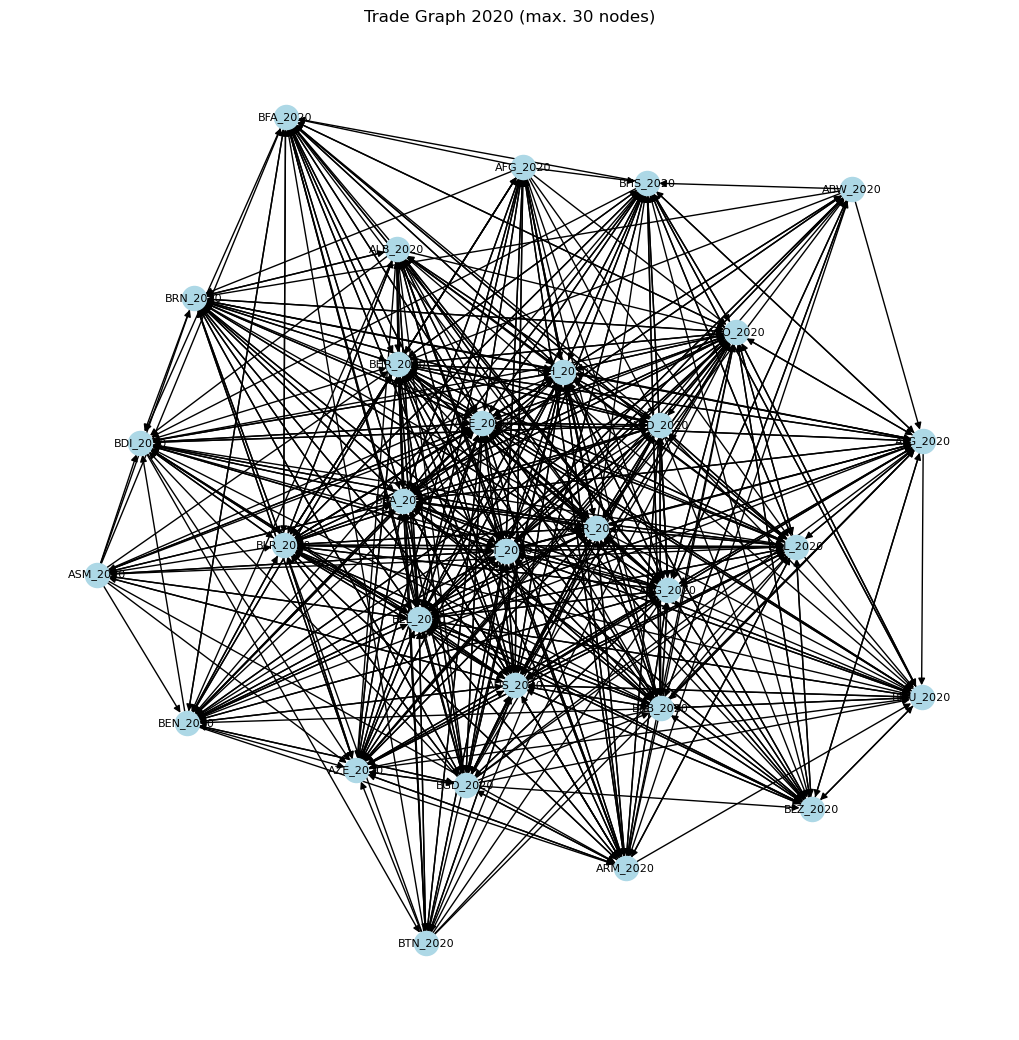

In [24]:
import matplotlib.pyplot as plt
import networkx as nx
import torch

def visualize_year(graph, year, max_nodes=30):
    y_idx = graph.years.index(year)
    start = graph.year_ptr[y_idx].item()
    end = graph.year_ptr[y_idx + 1].item()
    nodes_in_year = set(range(start, end))

    ei = graph.edge_index
    edge_mask = [(src.item() in nodes_in_year and tgt.item() in nodes_in_year) for src, tgt in ei.T]
    edges_in_year = ei[:, edge_mask]

    node_ids = set(edges_in_year[0].tolist() + edges_in_year[1].tolist())

    if len(node_ids) > max_nodes:
        node_ids = set(sorted(list(node_ids))[:max_nodes])  

    # Filter edges
    filtered_edges = [
        (src.item(), tgt.item())
        for src, tgt in edges_in_year.T
        if src.item() in node_ids and tgt.item() in node_ids
    ]

    labels = {
    i: graph.node_labels[i] if hasattr(graph, "node_labels") else str(i)
    for i in node_ids
    }

    # create Network graph
    G = nx.DiGraph()
    G.add_edges_from(filtered_edges)

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, seed=42)  
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=300, node_color="lightblue", font_size=8, arrows=True)
    plt.title(f"Trade Graph {year} (max. {len(node_ids)} nodes)")
    plt.show()

visualize_year(big_graph, year=2020, max_nodes=30)

In [25]:
# node data
df_nodes = pd.DataFrame(
    big_graph.x.numpy(),
    index=big_graph.node_labels,
    columns=["gdp", "gdp_per_capita", "gov_spending"]
)
df_nodes.index.name = "country_year"

# Split in ISO3 + year
df_nodes = df_nodes.reset_index()
df_nodes[['ISO3', 'year']] = df_nodes['country_year'].str.split('_', expand=True)
df_nodes['year'] = df_nodes['year'].astype(int)

cols = ['ISO3', 'year', 'gdp', 'gdp_per_capita', 'gov_spending']
df_nodes = df_nodes[cols]

print("Nodes:")
display(df_nodes.head(5))


# edge data
edge_index = big_graph.edge_index.numpy()
edge_weight = big_graph.edge_weight.numpy() if hasattr(big_graph, "edge_weight") else None

src = edge_index[0]
dst = edge_index[1]

df_edges = pd.DataFrame({
    "source": [big_graph.node_labels[i] for i in src],
    "target": [big_graph.node_labels[i] for i in dst],
    "weight": edge_weight if edge_weight is not None else 1.0
})

df_edges[['src_ISO3', 'year']] = df_edges['source'].str.split('_', expand=True)
df_edges[['tgt_ISO3', _]] = df_edges['target'].str.split('_', expand=True) 
df_edges['year'] = df_edges['year'].astype(int)

df_edges = df_edges[['src_ISO3', 'tgt_ISO3', 'year', 'weight']]

print("\nEdges:")
display(df_edges.head(5))




Nodes:


,ISO3,year,gdp,gdp_per_capita,gov_spending
0,ABW,2000,-0.170822,0.852447,0.000000
1,AFG,2000,-0.170034,-0.621073,-0.297991
2,AGO,2000,-0.167353,-0.593135,-0.202634
3,ALB,2000,-0.170004,-0.550258,-0.043908
4,AND,2000,-0.171032,0.933591,0.000000



Edges:


,src_ISO3,tgt_ISO3,year,weight
0,ABW,ATG,2000,1.593105
1,ABW,AUT,2000,6.258263
2,ABW,BEL,2000,9.909582
3,ABW,BGD,2000,0.298622
4,ABW,BGR,2000,6.859743


In [26]:
df_nodes.to_parquet("nodes_economics.parquet")
df_edges.to_parquet("edges_economics.parquet")
